## Keras Tutorial

http://keras.io

#### What is Keras?

> Keras is a high-level neural networks API, written in Python and capable of running on top of either TensorFlow or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

This tutorial is divided into the following parts:

1. Basic Keras funcionality
2. Deep Neural Networks Example
3. Convolutional Neural Networks Example
4. Denoising Autoencoder Example

### 1. Basic Keras Funcionality

#### Backends
- Theano and TensorFlow (CPU or GPU)

#### API Models
- Sequential and Functional
- Scikit-Learn API

#### Layer Types
- Core layers: Dense, Activation, Dropout, Flatten
- Convolutional layers: ConvXD, CroppingXD, UpSamplingXD
- Pooling Layers: MaxPoolingXD, AveragePoolingXD
- Recurrent Layers: LSTM, GRU
- Custom layers can be created

#### Preprocessing
- Sequence: pad_sequences, skip-grams
- Text: one_hot, text_to_word_sequence, Tokenizer
- Image: ImageDataGenerator (data augmentation)

#### Loss Functions
- categorical_crossentropy
- sparse_categorical_crossentropy
- binary_crossentropy
- mean_squared_error
- mean_absolute_error

#### Optimizers
- SGD
- RMSprop
- Adagrad
- Adadelta
- Adam
- Adamax
- TFOptimizer (wrapper for TensorFlow native optimizers)

#### Activations
- softmax
- elu
- relu
- tanh
- sigmoid
- hard_sigmoid
- linear

#### Initializers
- Zeros
- RandomNormal
- RandomUniform
- TruncatedNormal
- VarianceScaling
- Orthogonal
- Identity
- lecun_uniform
- glorot_normal
- glorot_uniform
- he_normal
- he_uniform

#### Callbacks
- ProgbarLogger: prints metrics to stdout
- ModelCheckpoint: save the model after every epoch
- EarlyStopping: stop training when a monitored quantity has stopped improving
- RemoteMonitor: callback used to stream events to a server
- LearningRateScheduler
- TensorBoard
- ReduceLROnPlateau: reduce learning rate when a metric has stopped improving
- CSVLogger: callback that streams epoch results to a csv file
- LambdaCallback: callback for creating simple, custom callbacks on-the-fly

#### Model Visualization
- plot_model


### 2. Deep Neural Networks Example

#### Loading MNIST data

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from keras.initializers import he_uniform
from keras.callbacks import EarlyStopping
%matplotlib inline 

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:]))
X_test = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:]))

X_train = X_train/255.0
X_test = X_test/255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)


#### Using the Sequential API

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

model = Sequential()
model.add(Dense(128, input_shape=(28*28,), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

stopper = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1)

model.fit(X_train, y_train, batch_size=32, epochs=2,
          validation_split=0.2, 
          verbose=1, callbacks = [stopper])

print('\nAccuracy: %.2f' % model.evaluate(X_test, y_test, verbose=1)[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 8s - loss: 0.2525 - acc: 0.9241 - val_loss: 0.1193 - val_acc: 0.9632

#### Using the Functional API

In [15]:
from keras.models import Model
from keras.layers import Input, Dense

input_data = Input(shape=(28*28,))
x = Dense(128, activation='relu')(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=input_data, outputs=x)

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

stopper = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1)

model.fit(X_train, y_train, batch_size=32, epochs=2,
          validation_split=0.2, 
          verbose=1, callbacks = [stopper])

print('\nAccuracy: %.2f' % model.evaluate(X_test, y_test, verbose=1)[1])


Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 8s - loss: 0.2512 - acc: 0.9241 - val_loss: 0.1230 - val_acc: 0.9630

#### Using the Scikit-Learn API

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score

def create_model():
    m = Sequential()
    m.add(Dense(128, input_shape=(28*28,), activation='relu'))
    m.add(Dense(128, activation='relu'))
    m.add(Dense(128, activation='relu'))
    m.add(Dense(10, activation='softmax'))

    m.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return m


stopper = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1)

model = KerasClassifier(build_fn=create_model)
model.fit(X_train, y_train, batch_size=32, epochs=2,
          validation_split=0.2, 
          verbose=1, callbacks = [stopper])

y_pred = model.predict(X_test)
y_pred = np_utils.to_categorical(y_pred, 10)

print('\nAccuracy: %.2f' % accuracy_score(y_test, y_pred))


Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 9s - loss: 0.2535 - acc: 0.9236 - val_loss: 0.1346 - val_acc: 0.9598

#### Using the Scikit-Learn API + Grid Search

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='adam', init='he_uniform', 
                 window_size=3, hidden_layer_size=128, activation='relu'):
    m = Sequential()
    m.add(Dense(hidden_layer_size, input_shape=(28*28,), activation='relu'))
    m.add(Dense(hidden_layer_size, activation='relu'))
    m.add(Dense(hidden_layer_size, activation='relu'))
    m.add(Dense(10, activation='softmax'))

    m.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return m


stopper = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1)

model = KerasClassifier(build_fn=create_model)

#optimizers = ['adam', 'sgd', 'rmsprop']
#inits = ['he_uniform', 'lecun_uniform', 'glorot_uniform']
#epochs = [1]
#batches = [32, 64]
#hidden_layer_sizes = [32, 64, 128]
#activations = ['relu', 'sigmoid', 'tanh']

optimizers = ['adam']
inits = ['he_uniform']
epochs = [2]
batches = [32]
hidden_layer_sizes = [64, 128]
activations = ['relu']

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, 
                  init=inits, hidden_layer_size=hidden_layer_sizes,
                  activation=activations)

fit_params = dict(validation_split=0.3,
                  verbose=1,
                  callbacks=[stopper])

grid = GridSearchCV(estimator=model, param_grid=param_grid, fit_params=fit_params, verbose=1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
grid_model = grid_result.best_estimator_

y_pred = grid_model.predict(X_test)
y_pred = np_utils.to_categorical(y_pred, 10)

print('\nAccuracy: %.2f' % accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Train on 28000 samples, validate on 12000 samples
Epoch 1/2
28000/28000 [==============================] - 4s - loss: 0.3937 - acc: 0.8795 - val_loss: 0.2416 - val_acc: 0.9271

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.4min finished


Train on 42000 samples, validate on 18000 samples
Epoch 1/2
42000/42000 [==============================] - 9s - loss: 0.2644 - acc: 0.9213 - val_loss: 0.1582 - val_acc: 0.9511

### 3. Convolutional Neural Networks Example

#### Reshaping MNIST data

In [18]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

#### Compiling and training a CNN

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers.convolutional import Conv2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                 input_shape=(28, 28, 1), 
                 kernel_initializer = he_uniform(seed=None)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

stopper = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, verbose=1)

model.fit(X_train, y_train, batch_size=32, epochs=2,
          validation_split=0.2, 
          verbose=1, callbacks = [stopper])

print('\nAccuracy: %.2f' % model.evaluate(X_test, y_test, verbose=1)[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 125s - loss: 0.2208 - acc: 0.9318 - val_loss: 0.0597 - val_acc: 0.9832

### 4. Denoising Autoencoder Example

#### Reshaping MNIST data + generating noisy data

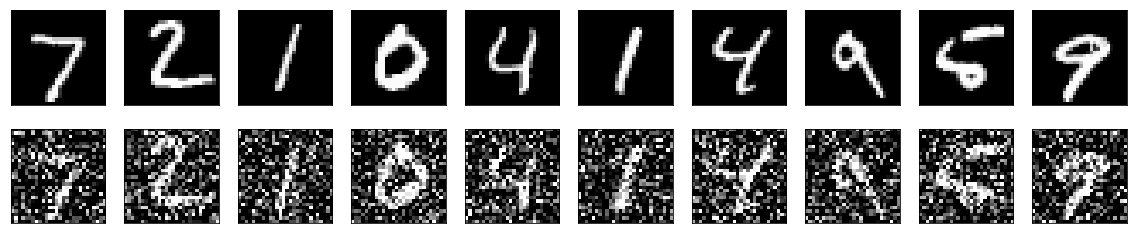

In [20]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Compiling and training a Denoising Autoencoder

In [21]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
encoded = MaxPooling2D((2, 2), padding='same')
model.add(encoded)

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
model.add(decoded)

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_noisy, X_train, epochs=1, batch_size=32, shuffle=True, verbose=1, validation_split=0.3)

X_test_denoised = model.predict(X_test_noisy)

Train on 42000 samples, validate on 18000 samples
Epoch 1/1
42000/42000 [==============================] - 151s - loss: 0.1524 - acc: 0.8052 - val_loss: 0.1160 - val_acc: 0.8112

#### Compiling and training a Denoising Autoencoder

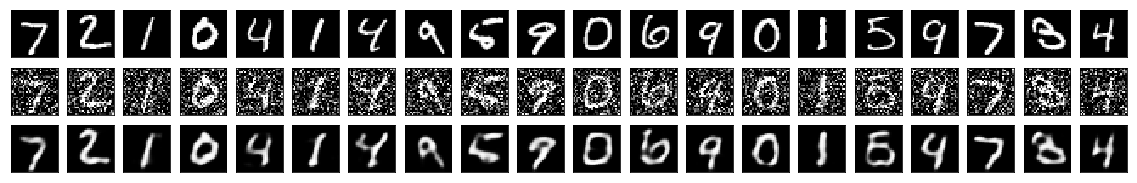

In [29]:
n = 20
plt.figure(figsize=(20, 3))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+2*n+1)
    plt.imshow(X_test_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()